In [51]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [39]:
data = pd.read_csv("kickstarter_data.csv")
data['success_rate'] = data['pled'] / data['goal']

In [40]:
df = data[data['goal'] >= 5]

In [41]:
df.fillna(df.median())

C:\Users\belol\AppData\Local\Temp/ipykernel_7416/2553712938.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.median())


,Unnamed: 0,URL,pled,goal,date,period,status,text_am,n_img,n_vid,...,indie,action,quest,adventure,mgp,cont,curr,succsess,is_site,success_rate
0,8438,https://www.kickstarter.com/projects/577038691...,16.37,16368.00,2013-12-01,14,ended,355,7,0,...,0,0,0,0,0.653856,0.276952,GBP,0,0,0.001000
1,3182,https://www.kickstarter.com/projects/200047954...,124761.28,7278.02,2015-08-03,30,ended,2218,33,3,...,0,1,0,0,6.105621,0.220415,AUD,1,1,17.142201
2,7977,https://www.kickstarter.com/projects/85660245/...,1211.00,35000.00,2013-04-12,31,ended,3174,19,3,...,1,0,0,0,2.556285,0.289384,USD,0,1,0.034600
3,1270,https://www.kickstarter.com/projects/193393221...,1.00,10000.00,2013-11-13,14,ended,110,0,0,...,0,0,0,0,0.000000,0.000000,USD,0,1,0.000100
4,6312,https://www.kickstarter.com/projects/148102341...,5415.00,67000.00,2016-04-25,30,ended,3955,46,1,...,0,1,0,1,5.987628,0.256332,USD,0,1,0.080821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8416,8202,https://www.kickstarter.com/projects/501263634...,2246.00,7000.00,2014-03-11,60,ended,912,10,0,...,1,0,1,0,3.246320,0.220351,USD,0,1,0.320857
8417,3125,https://www.kickstarter.com/projects/154070452...,18021.00,15000.00,2015-09-22,45,ended,1650,39,2,...,0,0,0,0,8.707396,0.230234,USD,1,1,1.201400
8418,322,https://www.kickstarter.com/projects/101642300...,14.00,10000.00,2016-02-17,30,ended,280,10,1,...,0,0,0,0,2.763008,0.328798,USD,0,0,0.001400
8419,1098,https://www.kickstarter.com/projects/173840524...,82.88,3928.54,2014-05-31,31,ended,777,0,0,...,0,0,1,0,0.000000,0.000000,CAD,0,0,0.021097


In [42]:
def get_type(rate):
    type_ = 0
    for i in np.linspace(0, 1.75, 8):
        if rate < i + 0.25:
            return type_
        type_ += 1
    return 8

In [43]:
# Add success type

types = []

for idx, row in df.iterrows():
    types.append(get_type(row[-1]))

types = pd.Series(types, dtype=int)
df = df.assign(succes_type=types.values)
if 'success_rate' in df.columns:
    df = df.drop(columns='success_rate')
if 'success' in df.columns:
    df = df.drop(columns='success')

In [44]:
numeric_data = df.corr().columns[1:]
target_col = df.corr().columns[-1]

print(numeric_data, target_col)

df = df[numeric_data]
target = df[target_col]

Index(['pled', 'goal', 'period', 'text_am', 'n_img', 'n_vid', 'n_pled_t',
       'min_pled_t', 'max_pled_t', 'mean_pled_t', 'step_pled_t', 'cr_time',
       'backed', 'created', 'rpg', 'platformer', 'shooter', 'fighting',
       'survival', 'horror', 'strategy', 'arcade', 'simulator', 'mmo', 'indie',
       'action', 'quest', 'adventure', 'mgp', 'cont', 'succsess', 'is_site',
       'succes_type'],
      dtype='object') succes_type


In [45]:
model = nn.Sequential(
    nn.Linear(32, 24),
    nn.ReLU(),
    nn.BatchNorm1d(24),
    nn.Linear(24, 20),
    nn.ReLU(),
    nn.Linear(20, 10))

optimizer = Adam(model.parameters())
loss_fn = F.cross_entropy

In [46]:
class MyDataset:
    def __init__(self, df):
        self.df = pd.DataFrame(data=df)
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, i):
        return torch.Tensor(df.iloc[i])[:-1], torch.Tensor(df.iloc[i])[-1].to(torch.long)

In [47]:
from torch.utils.data import DataLoader


train, test = train_test_split(df, train_size=0.8)

train_loader = DataLoader(MyDataset(train), batch_size=24, shuffle=True)
test_loader = DataLoader(MyDataset(test), batch_size=24)

In [48]:
model.train()

losses = []
accuracies = []

for epochs in tqdm(range(10)):
    epoch_losses = []
    epoch_accuracies = []
    for xb, yb in tqdm(train_loader):
        accuracy = 0
        correct_answers = 0
        
        optimizer.zero_grad()

        outp = model(xb)
        loss = loss_fn(outp, yb)

        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        
        correct_answers = (outp.argmax(-1) == yb).sum()
        accuracy = correct_answers / xb.shape[0]
        epoch_accuracies.append(accuracy)
    
    losses.append(torch.tensor(epoch_losses).mean())
    accuracies.append(torch.tensor(epoch_accuracies).mean())
    
    print('loss:', losses[-1])
    print('accuracy: ', accuracies[-1])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

loss: tensor(1.2064)
accuracy:  tensor(0.7026)


  0%|          | 0/281 [00:00<?, ?it/s]

loss: tensor(0.7058)
accuracy:  tensor(0.7817)


  0%|          | 0/281 [00:00<?, ?it/s]

loss: tensor(0.6339)
accuracy:  tensor(0.7920)


  0%|          | 0/281 [00:00<?, ?it/s]

loss: tensor(0.5893)
accuracy:  tensor(0.8092)


  0%|          | 0/281 [00:00<?, ?it/s]

loss: tensor(0.5494)
accuracy:  tensor(0.8135)


  0%|          | 0/281 [00:00<?, ?it/s]

loss: tensor(0.5319)
accuracy:  tensor(0.8207)


  0%|          | 0/281 [00:00<?, ?it/s]

loss: tensor(0.5208)
accuracy:  tensor(0.8206)


  0%|          | 0/281 [00:00<?, ?it/s]

loss: tensor(0.5254)
accuracy:  tensor(0.8274)


  0%|          | 0/281 [00:00<?, ?it/s]

loss: tensor(0.5034)
accuracy:  tensor(0.8319)


  0%|          | 0/281 [00:00<?, ?it/s]

loss: tensor(0.4944)
accuracy:  tensor(0.8345)


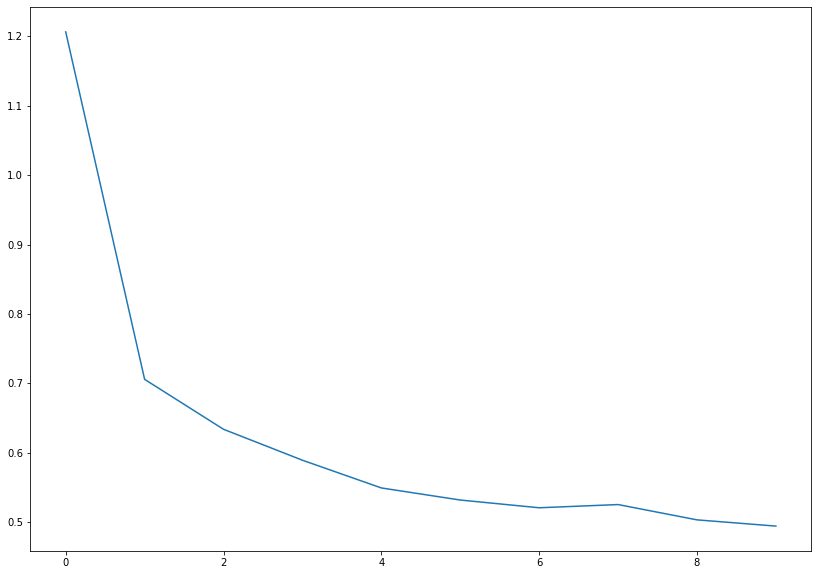

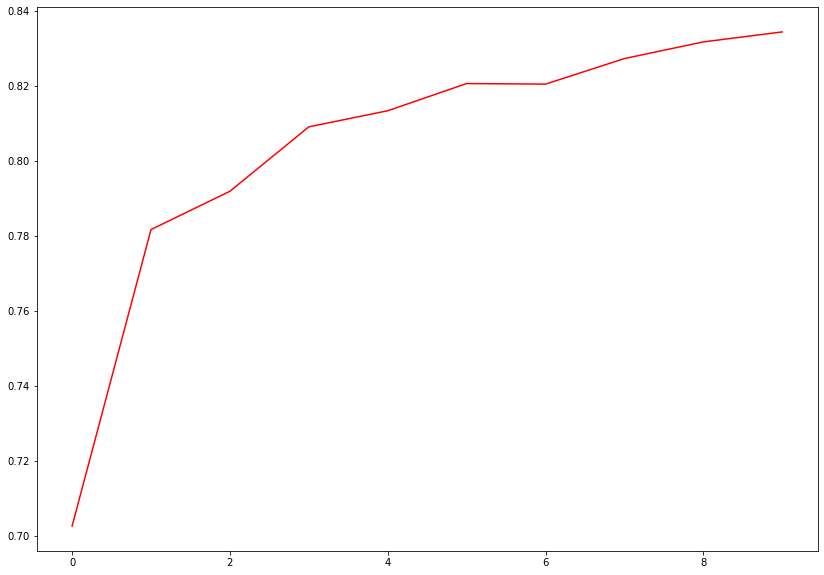

In [52]:
plt.figure(figsize=(14, 10))
plt.plot(range(epochs + 1), losses, label='loss')

plt.figure(figsize=(14, 10))
plt.plot(range(epochs + 1), accuracies, label='accuracy', c='r')

In [53]:
model.eval()

losses = []
accuracies = []

for xb, yb in test_loader:
    with torch.no_grad():
        outp = model(xb)
        correct_answers = (outp.argmax(-1) == yb).sum()
        accuracy = correct_answers / xb.shape[0]
        accuracies.append(accuracy)
torch.Tensor(accuracies).mean()

tensor(0.8052)

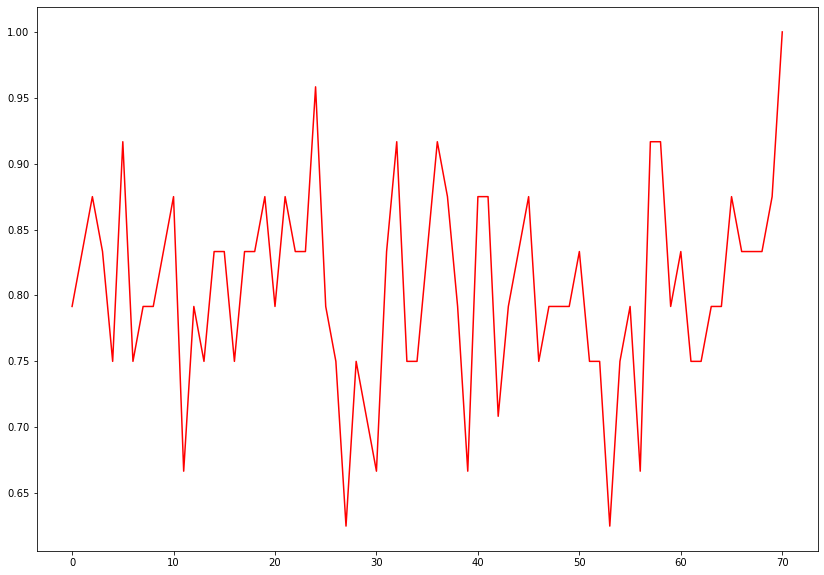

In [54]:
plt.figure(figsize=(14, 10))
plt.plot(np.arange(len(test_loader)), accuracies, label='accuracy', c='r')